Reinforcement learning methods to a simple card game
The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a color of red (probability 1/3) or black (probability 2/3).
-- There are no aces or picture (face) cards in this game.
At the start of the game, both the player and the dealer
draw one black card (fully observed).
•
Each turn the player may either stick or hit.
•
If the player hits, then she draws another card from the deck.
•
If the player sticks, she receives no further cards.
The values of the player’s cards are added (black cards) or subtracted (red cards)
If the player’s sum exceeds 21 or becomes less than 1, then she “goes bust” and loses the game (reward -1)
If the player sticks, then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [1]:
# Importing required Libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

An environment that implements the game. Specifically, write a function, named step, which takes as input a state s (dealer’s first card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns a sample of the next state s′ (which may be terminal if the game is finished) and reward r. We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

In [2]:

def draw_card():
    """Drawing a card from the deck."""
    cardValue = np.random.randint(1, 11)
    cardColor = np.random.choice(['red', 'black'], p=[1/3, 2/3])
    return cardValue if cardColor == 'black' else -cardValue

def step(dealer_card, player_sum, action):
    """Actions"""
    if action == 'hit':
        card = draw_card()
        player_sum += card
        if player_sum > 21 or player_sum < 1:
            return 'end', -1
        else:
            return (dealer_card, player_sum), 0
    elif action == 'stick':
        while dealer_card < 17:
            card = draw_card()
            dealer_card += card
        if dealer_card > 21 or dealer_card < 1:
            return 'end', 1
        elif dealer_card < player_sum:
            return 'end', 1
        elif dealer_card > player_sum:
            return 'end', -1
        else:
            return 'end', 0

Applying Monte-Carlo control to this problem. Initialize the value function to zero. Use a time-varying scalar step-size of αt = 1/N(st, at) and an ϵ-greedy exploration strategy with ϵt = N0/(N0 + N(st)), where N0 = 100 is a constant, N (s) is the number of times that state s has been visited, and N (s, a) is the number of times that action a has been selected from state s.

In [3]:
def monte_carlo_control(num_episodes):
    epsilon=0.1
    N0=100
    Q = {}  # Dictionary to store action-value function Q(s, a)
    N = {}  # Dictionary to store number of visits to state-action pairs

    for episode in range(1, num_episodes + 1):
        states_visited = []
        actions_taken = []

        dealer_card, player_card = np.random.randint(1, 11), np.random.randint(1, 11) #initially black card
        done = False

        while not done:
            state = (dealer_card, player_card)  # Initial state

            # Epsilon-greedy policy
            if state in Q and np.random.uniform() < epsilon / (epsilon + sum(N[state].values())):
                action = np.random.choice(list(Q[state].keys()))
            else:
                action = 'hit' if np.random.rand() < 0.5 else 'stick'

            next_state, reward = step(dealer_card, player_card, action)
            states_visited.append(state)
            actions_taken.append(action)

            if next_state != 'end':
                dealer_card, player_sum = next_state

            if state not in Q:
                Q[state] = {}
                N[state] = {}

            if action not in Q[state]:
                Q[state][action] = 0
                N[state][action] = 0

            N[state][action] += 1
            alpha = 1 / N[state][action]
            Q[state][action] += alpha * (reward - Q[state][action])

            if next_state == 'end':
                done = True

    return Q

For MonteCarlo:  Plot the optimal value function V ∗(s) = maxa Q∗(s, a) using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.

In [4]:
num_episodes = 1000 
monte_carlo_qvalues = monte_carlo_control(num_episodes)
max_q_values, true_q_values = np.zeros((21, 10, 2)),  np.zeros((21, 10, 2))  # Dimensions: player's sum, dealer's showing card, action (hit or stick)

for state, actions in monte_carlo_qvalues.items():
    player_sum, dealer_card = state
    for action, value in actions.items():
        if action == 'hit':
            action_index = 0
        else:
            action_index = 1
        max_q_values[player_sum - 1, dealer_card - 1, action_index] = max(max_q_values[player_sum - 1, dealer_card - 1, action_index], value)
        true_q_values[player_sum - 1, dealer_card - 1, action_index] = value
V_star = np.max(max_q_values, axis=2)

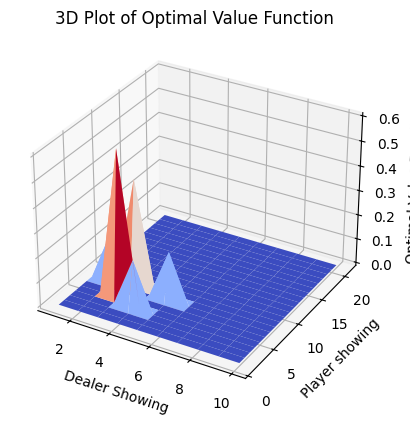

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(1, 11), range(1, 22))
surf = ax.plot_surface(X, Y, V_star, cmap=cm.coolwarm)
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player showing')
ax.set_zlabel('Optimal Value Function')
ax.set_title('3D Plot of Optimal Value Function')
plt.show()

Implement Sarsa(λ). Initialize the value function to zero. Use the same step size and exploration schedules as in the previous section.

In [6]:
# converting the trueqvalues to dict to match with sarsa
true_q_values_dict = {}
for i in range(true_q_values.shape[0]):
    for j in range(true_q_values.shape[1]):
        true_q_values_dict[(i, j)] = true_q_values[i, j]

In [7]:
def sarsa_lambda(num_episodes, lmbda):
    Q = {}  # Action-value function
    N0 = 100  # Constant for exploration schedule
    dealer_card = np.random.randint(1, 11) # initially drawing positive value, i.e black card
    player_card = np.random.randint(1, 11)  # initially drawing positive value, i.e black card
    alpha = 0.1  # Learning rate
    gamma = 1  # Discount factor
    mse_episodes = []
    for episode in range(num_episodes):
        eligibility_trace = {}  # Eligibility trace for each state-action pair
        state = (dealer_card, player_card)  # Initial state
        if state not in Q:
            Q[state] = np.zeros(2)  # Initialize action values

        action = np.random.choice(['hit', 'stick'])  # Initial action
        while state != 'end':
            next_state, reward = step(state[0], state[1], action)
            if next_state != 'end':
                next_action = np.random.choice(['hit', 'stick'])  # Next action
                if next_state not in Q:
                    Q[next_state] = np.zeros(2)  # Initialize action values

                # Update eligibility trace
                eligibility_trace[(state, action)] = eligibility_trace.get((state, action), 0) + 1

                # TD error
                td_error = reward + Q[next_state][next_action == 'stick'] - Q[state][action == 'stick']

                # Update Q-values and eligibility trace
                for (s, a), e in eligibility_trace.items():
                    Q[s][a == 'stick'] += alpha * e * td_error
                    eligibility_trace[(s, a)] *= lmbda * gamma

                state, action = next_state, next_action
            else:
                # Update eligibility trace and Q-values for terminal state
                eligibility_trace[(state, action)] = eligibility_trace.get((state, action), 0) + 1
                td_error = reward - Q[state][action == 'stick']
                for (s, a), e in eligibility_trace.items():
                    Q[s][a == 'stick'] += alpha * e * td_error
                    eligibility_trace[(s, a)] *= lmbda * gamma
                break
        # Calculate mean squared error for each episode
        mse = 0
        for state_action, true_q in true_q_values_dict.items():
            if state_action in Q:
                mse += np.mean((true_q - Q[state_action]) ** 2)
        mse /= len(true_q_values) 
        mse_episodes.append(mse)
    return Q, mse_episodes

Stop each run  after  1000  episodes  and  report  the  mean-squared  error over  all  states  s and  actions  a,  comparing  the true values  Q∗(s,  a) computed in the previous  section with the estimated  values  Q(s, a)  computed  by  Sarsa.

In [8]:
lmbdas = np.arange(0, 1.1, 0.1)
num_episodes = 1000 
mse_values = np.zeros_like(np.arange(0, 1.1, 0.1)) 
mse_episode_dict = {}
for lmbda in lmbdas:
    sarsa_q_values, mse_episodes = sarsa_lambda(num_episodes, lmbda)
    mse_episode_dict[lmbda] = mse_episodes
    common_state_actions = set(sarsa_q_values.keys()) & set(true_q_values_dict.keys())
    for state_action in common_state_actions:
        mse_values[state_action[0]] += np.mean((true_q_values[state_action[0], state_action[1]] - sarsa_q_values.get(state_action, np.zeros_like(true_q_values[0, 0]))) ** 2)

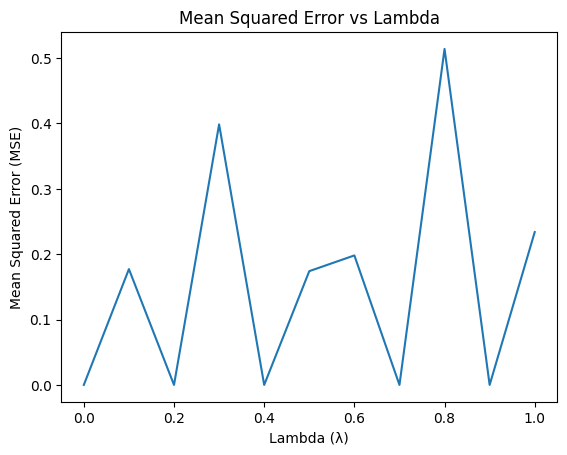

In [9]:
lambda_values = np.arange(0, 1.1, 0.1)
mse_values /= len(common_state_actions)
plt.plot(lambda_values, mse_values)
plt.xlabel('Lambda (λ)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error vs Lambda')
plt.show()

For  λ =  0  and  λ =  1  only,  plot  the learning curve of mean-squared error against episode number. 

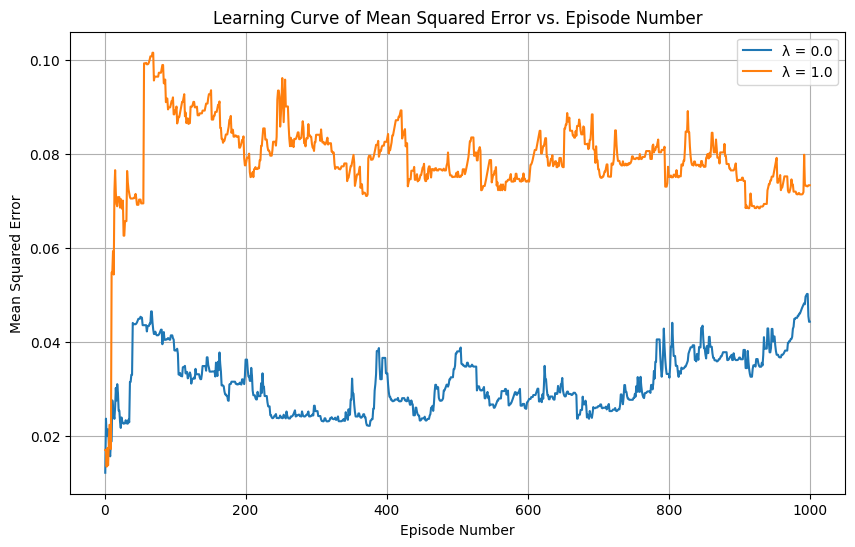

In [10]:
plt.figure(figsize=(10, 6))
for lmbda, mse_episodes in mse_episode_dict.items():
    if lmbda == 0 or lmbda == 1:
        plt.plot(range(1, num_episodes + 1), mse_episodes, label=f'λ = {lmbda}')

plt.title('Learning Curve of Mean Squared Error vs. Episode Number')
plt.xlabel('Episode Number')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()